In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
print(device)

cuda


In [2]:
data_folder = '~/data/MNIST' # This can be any directory you
mnist_train = datasets.MNIST(
    root=data_folder,
    train=True,
    download=True
)

tr_images = mnist_train.data
tr_targets = mnist_train.targets

# Load test data
mnist_test = datasets.MNIST(
    root=data_folder,
    train=False,
    download=True
)

te_images = mnist_test.data
te_targets = mnist_test.targets

print("Train images:", tr_images.shape)
print("Train labels:", tr_targets.shape)
print("Test images:", te_images.shape)
print("Test labels:", te_targets.shape)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 145kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.44MB/s]

Train images: torch.Size([60000, 28, 28])
Train labels: torch.Size([60000])
Test images: torch.Size([10000, 28, 28])
Test labels: torch.Size([10000])


Image (#53): Which is digit '4'


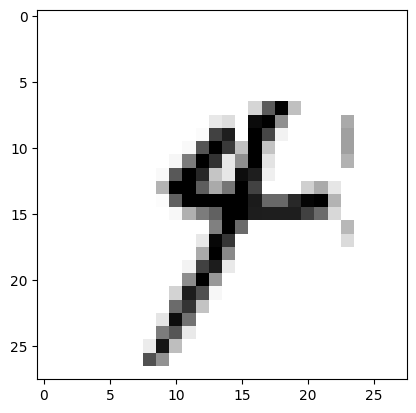

In [3]:
digit = np.random.randint(1, 100) # random new digit
a = tr_images[digit]
plt.imshow(a, cmap='gray_r')
print(f"Image (#{digit}): Which is digit '{tr_targets[digit]}'")

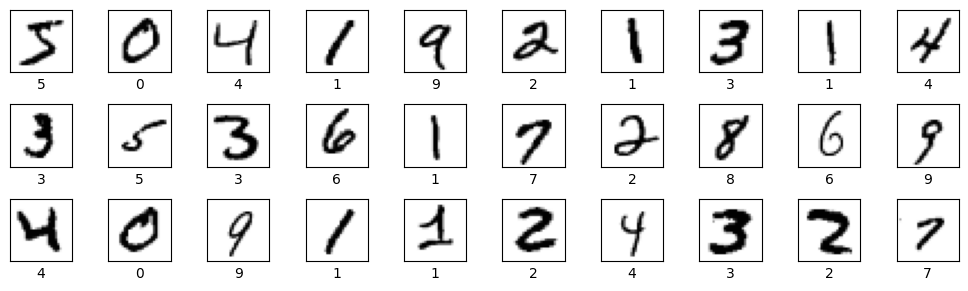

In [4]:
ROWS = 3
COLS = 10
i = 0

plt.figure(figsize=(10,3))
for r in range(ROWS):
    for c in range(COLS):
        plt.subplot(ROWS, COLS, i+1)
        plt.imshow(tr_images[i], cmap="gray_r")
        
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f"{tr_targets[i]}")
        i += 1
plt.tight_layout()
plt.show() 

In [5]:
class MNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255.0
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [6]:
def get_train_data():
    train = MNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=1, shuffle=True)
    return trn_dl
    
def get_test_data():
    test = MNISTDataset(te_images, te_targets)
    te_dl = DataLoader(test, batch_size=1, shuffle=True)
    return te_dl

In [7]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 10)
            ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    return model, loss_fn, optimizer

In [8]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach
    # dropout section
    # call your model like any python function on your batch
    # of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the
    # gradients of 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients)
    # where "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [9]:
# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout
    # section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row
    # coincides with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [10]:
trn_dl = get_train_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []

from tqdm.notebook import tqdm
training_epoch = 10
for epoch in tqdm(range(training_epoch),desc="Training : "):
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(tqdm(trn_dl,desc=f"Epoch {epoch+1}"))):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

Training :   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/60000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/60000 [00:00<?, ?it/s]

/tmp/ipykernel_24/1729220428.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


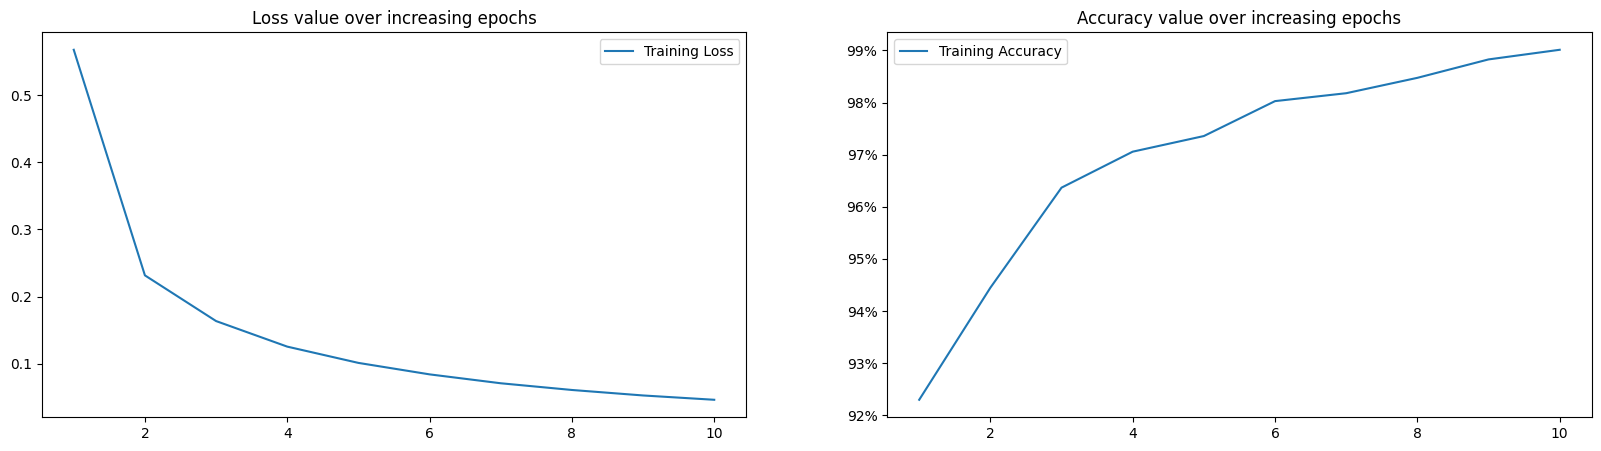

In [11]:
epochs = np.arange(training_epoch) + 1
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("Loss value over increasing epochs")
plt.plot(epochs, losses, label="Training Loss")
plt.legend()
plt.subplot(122)
plt.title("Accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="Training Accuracy")
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

In [12]:
te_dl = get_test_data()
test_accuracy = []
for ix, batch in enumerate(iter(te_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        test_accuracy.extend(is_correct)
test_accuracy = np.mean(epoch_accuracies)
print(test_accuracy)

0.9901166666666666
